# Milestone P4 - Creative extension

### Libraries, Import & Functions

In [5]:
#import libraries to use dataframes and basic feartures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#logistic regression
from sklearn.linear_model import LogisticRegression, LinearRegression

#Tool for prediction analysis
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc as computeAUC
from sklearn.model_selection import KFold

#Radom Forest & Gradient boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance

In [6]:
#Import the datasets
#Civil War Dataset (CWD)
DATA_FOLDER = 'data/'
DATASET = DATA_FOLDER+"SambnisImp.csv"

#Terrorism dataset
DATASET_TERROR = DATA_FOLDER+"globalterrorismdb_0919dist.xlsx"
DATASET_CID = DATA_FOLDER+"Sambanis_cid.dta"

#Opening and loading of files
df = pd.read_csv(DATASET, error_bad_lines=False, warn_bad_lines=True)
#df_t = pd.read_excel(DATASET_TERROR, error_bad_lines=False, warn_bad_lines=True)
df_t = pd.read_excel(DATASET_TERROR)
df_t = df_t.set_index('eventid')

#Loading the cowcode dataframe
cow = pd.read_csv('data/COW country codes.csv')

In [7]:
#Reduction of the CWD to 91 variables + years + cow code
doc = df[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

In [8]:
#Creating dataframes according to the parameters that were taken into account by the different papers

#Fearon and Laitin (2003)
df2003 = doc [["warhist", "ln_gdpen", "lpopns", "lmtnest",
    "ncontig", "oil", "nwstate", "inst3", "pol4", "ef", "relfrac"]]

#Collier and Hoeffler (2004)
df2004 = doc[["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth",
    "warhist", "lmtnest", "ef", "popdense", "lpopns", "coldwar", "seceduc",
    "ptime"]]

#Hegre and Sambanis (2006)
df2006 = doc[["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]]

In [9]:
#Setting the y parameter wich is the occurence of a civil war => warstds
y = doc["warstds"]

In [68]:
#Dictionary to transform features into names
dico = { 
'ager':'Age in years of the current regime',
'agexp': 'Agricultural raw materials exports as % of merchandise exports',
'anoc' : 'Anocracy',
'army85' : 'Size of government army in 1985',
'autch98' :'Autocracy annual change',
'auto4' : 'Autocracy index from Polity IV',
'autonomy' :'Country has de facto autonomous regions',
'avgnabo' : 'Average SIP score of neighbors',
'centpol3' : 'Centralized state?',
'demch98' : 'Democracy annual change',
'dlang' : 'Linguistic component of Ehet',
'drel' : 'Religious component of Ehet',
'durable' : 'Years since last regime transition since 1949',
'ef' : 'Ethnic fractionalization index',
'ef2' : 'Ef squared',
'ehet' : 'Ethnic heterogeneity index',
'elfo' : 'Ethnolinguistic diversity',
'elfo2' : 'Ethnolinguistic diversity, squared',
'etdo4590' : 'Ethnic dominance measure',
'expgdp' : 'Exports of goods & services as % GDP',
'exrec' : 'Executive recruitment concept variable',
'fedpol3' : 'Federal state?',
'fuelexp' : 'Fuel and oil products exports as % of merchandise exports',
'gdpgrowth' : 'Annual change in GDP, %',
'geo1' : 'Region: Western Europe and the US',
'geo2' : 'Region: Eastern Europe and Central',
'geo34' : 'Region: Middle East and North Africa',
'geo57' : 'Region: South and East Asia and Oceania',
'geo69' : 'Region: Latin America',
'geo8' : 'Region: Sub-Saharan Africa',
'illiteracy' : '% adult population illiterate; WDI',
'incumb' : 'Consolidation of incumbent advantage',
'infant' : 'Infant mortality',
'inst' : '0-dict; 1-parliam; 2-mixed dem; 3-pres dem',
'inst3' : 'Political instability',
'life' : 'Life Expectancy at birth',
'lmtnest' : 'Rough terrain',
'major' : 'Majoritarian system',
'manuexp' : 'Manufactures exports as % of merchandise exports',
'milper' : 'Military manpower in thousands',
'mirps0' : 'Inconsistent polity',
'mirps1' : 'Caesaristic polity',
'mirps2' : 'Consistent autocracy',
'mirps3' : 'Consistent democracy',
'nat_war' : 'Whether a neighbor is at war in a given year.',
'ncontig' : 'Noncontiguous state',
'nmgdp' : 'Neighbors’ average ln(GDP per capita)',
'nmdp4_alt' : 'Neighbors’ median polity',
'numlang' : 'Number of languages in Ethnologue',
'nwstate' : 'New state',
'oil' : 'Oil exports/GDP',
'p4mchg' : 'Annual change in modified polity',
'parcomp' : 'Competitiveness of participation; non-elites',
'parreg' : 'Regulation of participation',
'part' : 'ln(share of population voting x opposition’s share of votes cast)',
'partfree' : 'Partially free polity',
'plural' : 'Share of largest ethnic group',
'plurrel' : 'Size of largest confession',
'pol4' : 'Polity index',
'pol4m' : 'Polity Index',
'pol4sq' : 'Pol4 squared',
'polch98' : 'Polity annual change',
'polcomp' : 'Political competition: concept variable',
'popdense' : 'Population density: people persquare km',
'presi' : 'Presidential system',
'pri' : 'School enrollment, primary, %',
'proxregc' : '2^(-durable/.5)',
'reg' : 'Dummy: 1 for dictatorships and 0 for democracies',
'regd4_alt' : 'Median Regional polity',
'relfrac' : 'Religious fractionalization',
'seceduc' : 'School enrollment, secondary, % gross;',
'second' : 'Percent population in second largest group',
'semipol3' : 'Semi-federal state?',
'sip2' : 'Continuous measure of democracy',
'sxpnew' : 'Primary commodity exports/GDP',
'sxpsq' : 'Primary commodity exports/GDP, squared',
'tnatwar' : 'Total number of neighbors at war in a given year',
'warhist' : 'War in the country since 1945?',
'xconst' : 'Executive constraints - operational independence of CE'
}

In [11]:
#The code below is used to modify the dictionary features which have been changed to their evolution
ft = 'evolnmgdp'
evol=False
if('evol' in ft):
    evol=True
    ft=ft.replace('evol','')
if(ft in dico.keys()):
    ft = dico[ft]
if(evol):
    ft = 'evolution of '+ft        

In [12]:
def translate( fts ):
    translation = []
    for ft in fts:    
        evol=False
        if('evol' in ft):
            evol=True
            ft=ft.replace('evol','')
        if(ft in dico.keys()):
            ft = dico[ft]
        if(evol):
            ft = 'evolution of '+ft
            
        translation.append(ft)
        
    return translation

In [13]:
#Function that will plot ROC curves of different sets of data that have undergo a n-fold cross validation
#Parameters: model = classifier or model that we want to observe, Xs, Ys = sets of data, n = number of fold cross validation, labels = labels for plot
#newplot = if you want to display several plots, displaymean = show the mean created by the cross-validation
#each = variable that allow the plot of every ROC curves
def rocList(model,Xs,Ys,n=10,labels = [] ,each=False,newplot=True,displaymean = True):
    
    means_x=[]
    means_y=[]
    means_auc=[]
    for j in range(len(Ys)) :
        x=Xs[j]
        y=Ys[j]
    
        #Objects to store the calculated tpr (true positive rate), fpr(false positive rate) and auc (area under curve)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        kf = StratifiedKFold(n_splits=n)
        kf.split(x,y) 

        #For each fold, calculate the ROC-parametres (tpr, fpr and auc) and plot
        for i, (train_index, test_index) in enumerate(kf.split(x,y)):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            classifier  = model.fit(X_train, y_train)
            clf.fit(X_train,y_train)
            predictions = clf.predict_proba(X_test)[:,-1]
            falseRate, trueRate, threshold = metrics.roc_curve(y_test, predictions)
            interp_tpr = np.interp(mean_fpr, falseRate, trueRate)            
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

        #Calculate the mean of ROC-parametres
        mean_tpr = np.nanmean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = computeAUC(mean_fpr, mean_tpr)
        means_x.append(mean_fpr)
        means_y.append(mean_tpr)
        means_auc.append(mean_auc)
        
        #Display all the ROC curve in the cross validation
        if(each):
            plt.figure(figsize=(10,10))
            plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8)
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
            plt.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="")
            plt.legend(loc="lower right")
            plt.show()
    
    #Allow the automatic labelling
    if(len(labels)!=len(means_x)):
        labels = ['']*len(means_x)
    
    #Newplot -> for several plotting
    if (newplot): 
        plt.figure(figsize=(15,10))
    plt.title("Comparison of predictions from different datasets with a ROC plot")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    #To plot every curves at each step of the cross validation
    for i in range(len(means_x)):
        plt.plot(means_x[i],means_y[i],alpha = 0.8,label= labels[i] +' AUC: ' + str(round(means_auc[i],3)))
   
    #Calculation of the mean parameters
    over_x = np.mean( means_x ,axis = 0 )
    over_y = np.mean( means_y ,axis = 0 )
   
    #To display the mean done after the cross validation
    if (displaymean): plt.plot( over_x , over_y , 'k--' , label = 'Global Mean , AUC: ' + str(round(metrics.auc(over_x, over_y),3))  )
    plt.legend()

In [14]:
#Creation of a column of the evolution of a feature (must be numbers) by country, year to year in the CWD which will later replace it
#Returns vector of this evolution --> df['feature']= computeEvol(df,feature)
#The function needs the columns 'year' & 'cowcode'
#Parameters: df = dataset, feature = feature which we want to calculate the evolution

def computeEvol(df,feature):
    cow = df['cowcode'].unique()
    relative=[0]*len(df)
    for country in cow:
        tabCountry = df[ df['cowcode']==country ].sort_values(by='year')
        for year in tabCountry['year'].unique()[1:]:
            before = tabCountry[ tabCountry['year'] == year-1 ][feature].values[0]
            after = tabCountry[ tabCountry['year'] == year ][feature].values[0]
            if(before==0):
                #arbitrary high value when previous year is zero (10 ~ 1000%), multiplied by sign of the next year for the direction
                ratio = 10 * np.sign(after)
            else:ratio = (after-before)/before
            ind=df.loc[ (df['year'] == year) & (df['cowcode'] == country) ].index.values[0] 
            relative[ind]=ratio
    return relative

#Calcul : (y1-y0)/y0
#Exeption : if y0 = 0, we consider a 'big' variation of 10 ~ 1000%, in the direction of the evolution

### 1 _ Gradient Boosting

In [15]:
#Splitting of the dataset into a training and testing set, Creation of the y training and y testing
#Removing of the "warstds" which is the variable we want to predict so it should be erased from the X training and X testing
training_set,testing_set, y_train, y_test = train_test_split( doc.drop(["warstds", "year", "cowcode"],axis=1) , doc["warstds"], test_size=0.33,)

In [16]:
#Uncorrected Logistic regressions (LRs) with the parameters solver and max_iter because the number of iterations were not enough
#Fearon and Laitin (2003)
log2003 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2003,y)

#Collier and Hoeffler (2004)
log2004 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2004,y)

#Hegre and Sambanis (2006)
log2006 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2006,y)

#Creation of a Random Forest classifier with max_depth = 10 for CWD
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

#Creation of a Gradient Boosting Classifier with the same variables as the Random Forest model above
boostclf = GradientBoostingClassifier(n_estimators=100, max_depth=10)

In [17]:
#Calculations of the estimates and the AUC scores of the LRs
#Fearon and Laitin (2003)
probs = log2003.predict_proba(df2003)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

#Collier and Hoeffler (2004)
probs4 = log2004.predict_proba(df2004)
preds4 = probs4[:,1]
fpr4, tpr4, threshold4 = metrics.roc_curve(y, preds4)
roc_auc4 = metrics.auc(fpr4, tpr4)

#Hegre and Sambanis (2006)
probs6 = log2006.predict_proba(df2006)
preds6 = probs6[:,1]
fpr6, tpr6, threshold6 = metrics.roc_curve(y, preds6)
roc_auc6 = metrics.auc(fpr6, tpr6)

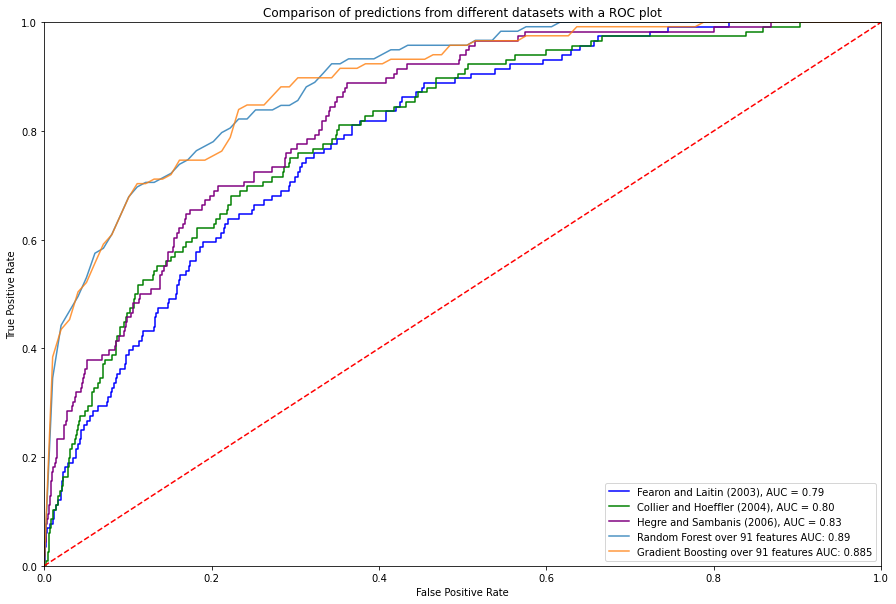

In [18]:
#ROC plot
plt.figure(figsize = (15,10))
plt.title('Comparison of different models predictions')

#Plotting of the 3 LR models
plt.plot(fpr, tpr, 'b', label = 'Fearon and Laitin (2003), '+'AUC = ' + '{:.2f}'.format(roc_auc)) 
plt.plot(fpr4, tpr4, 'green', label = 'Collier and Hoeffler (2004), '+'AUC = ' + '{:.2f}'.format( roc_auc4))
plt.plot(fpr6, tpr6, 'purple', label = 'Hegre and Sambanis (2006), '+'AUC = ' + '{:.2f}'.format( roc_auc6)) 

#Plotting of the RF and GB models
rocList(clf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['Random Forest over 91 features'], newplot = False, displaymean = False)
rocList(boostclf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['Gradient Boosting over 91 features'], newplot = False, displaymean = False)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
#Creation of a Series of feature importances or gini scores of the models (RF and GB)
feature_imp = pd.Series(clf.feature_importances_,index=training_set.columns).sort_values(ascending=False)
boost_feature_imp = pd.Series(boostclf.feature_importances_,index=training_set.columns).sort_values(ascending=False)

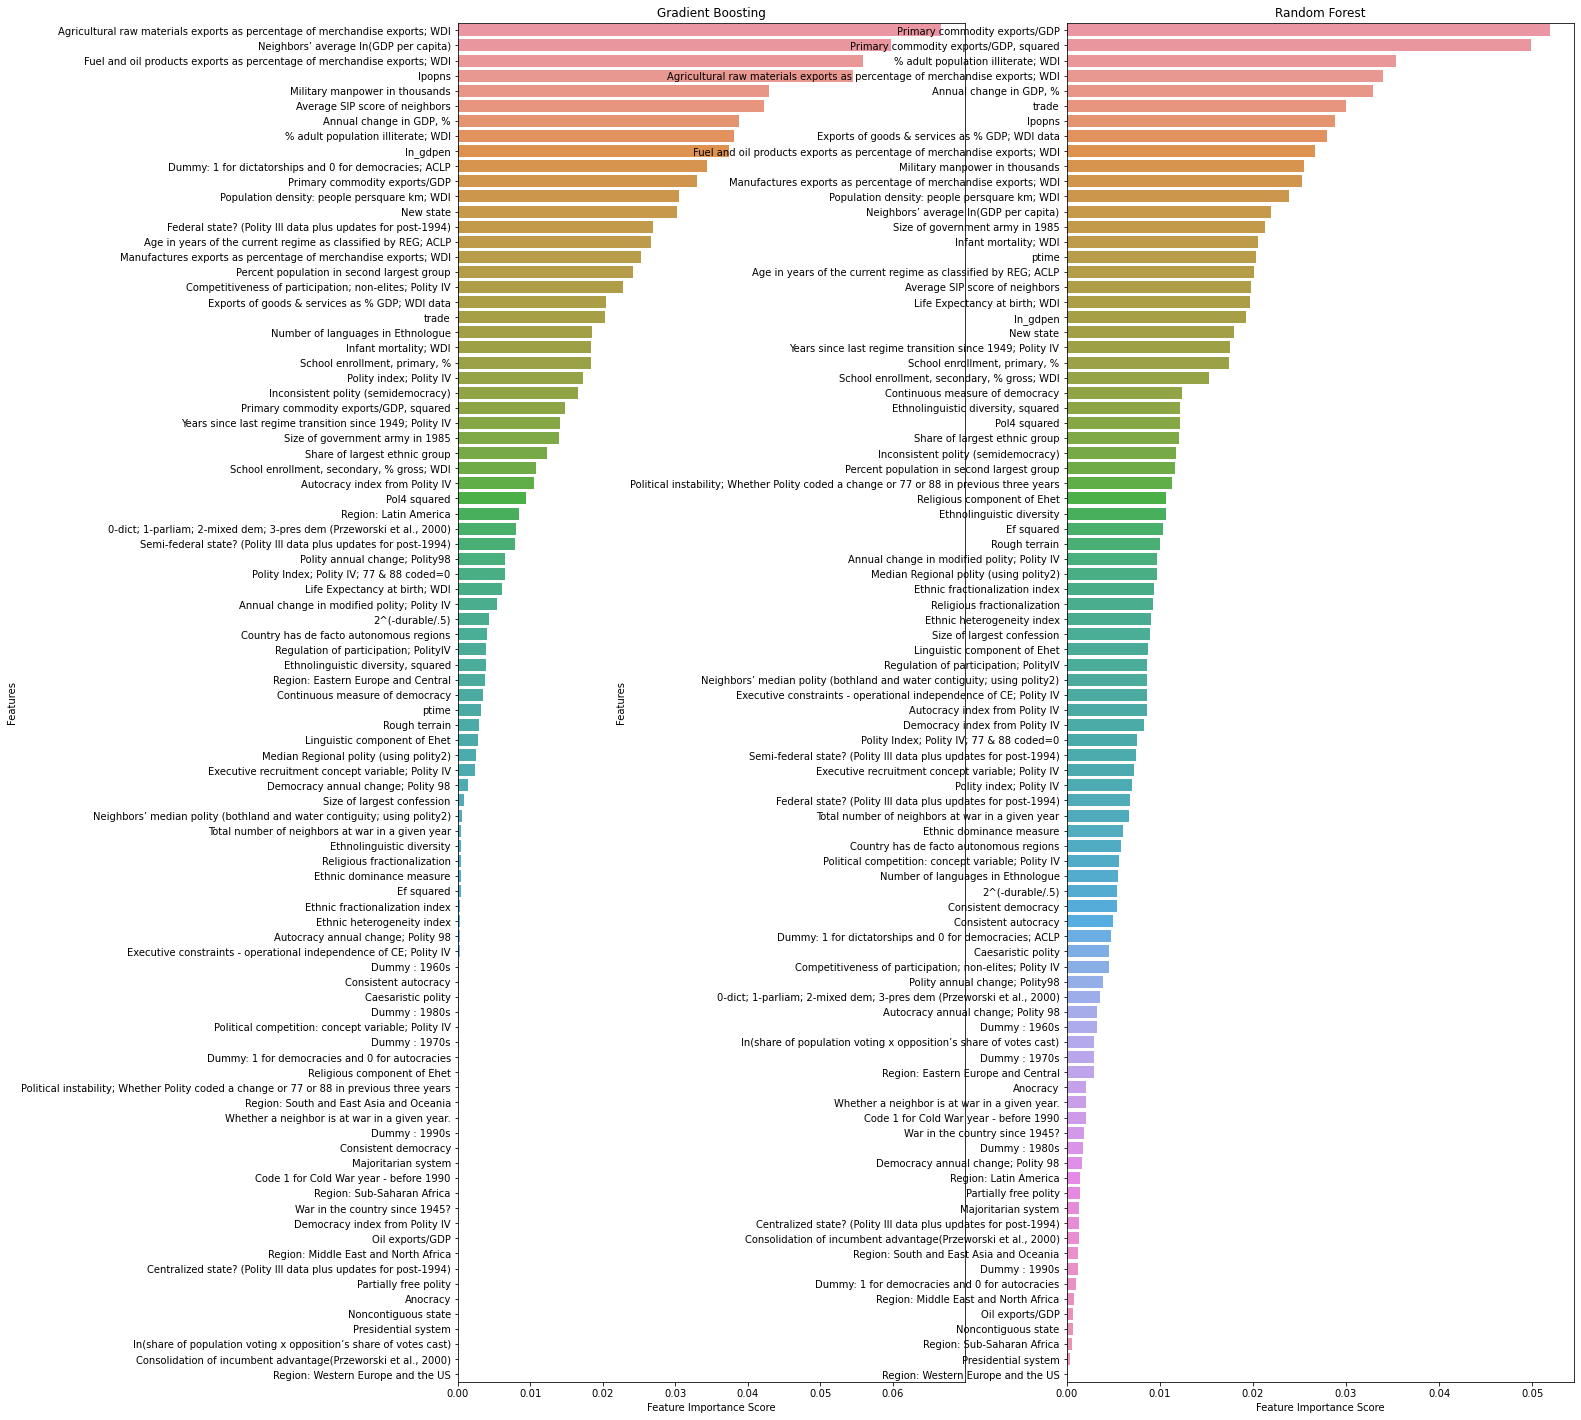

In [20]:
#Comparison of the features importance for the two models (RF and GB)
fig, ax = plt.subplots(1,2, figsize = (20,25))
sns.barplot(ax = ax[0],x=boost_feature_imp, y= translate(boost_feature_imp.index))
# Add labels to your graph
ax[0].set_xlabel('Feature Importance Score')
ax[0].set_ylabel('Features')
#ax[0].set_title("Visualizing Important Features")
ax[0].set_title("Gradient Boosting")
sns.barplot(ax = ax[1],x=feature_imp, y= translate(feature_imp.index))
# Add labels to your graph
ax[1].set_xlabel('Feature Importance Score')
ax[1].set_ylabel('Features')
#ax[1].set_title("Visualizing Important Features")
ax[1].set_title("Random Forest")
plt.show()

In [21]:
m1 = pd.DataFrame( feature_imp )
m2 = pd.DataFrame( boost_feature_imp ) 
merge = m1.merge(m2,left_index=True, right_index=True , )
merge.columns = ['Random Forest' , 'Gradient Boosting']
merge['tri']=merge['Random Forest']+merge['Gradient Boosting']
merge=merge.sort_values(by=['tri'], ascending=False)

Text(0.5, 0, 'Feature importances (on the left: RF, on the right: GB)')

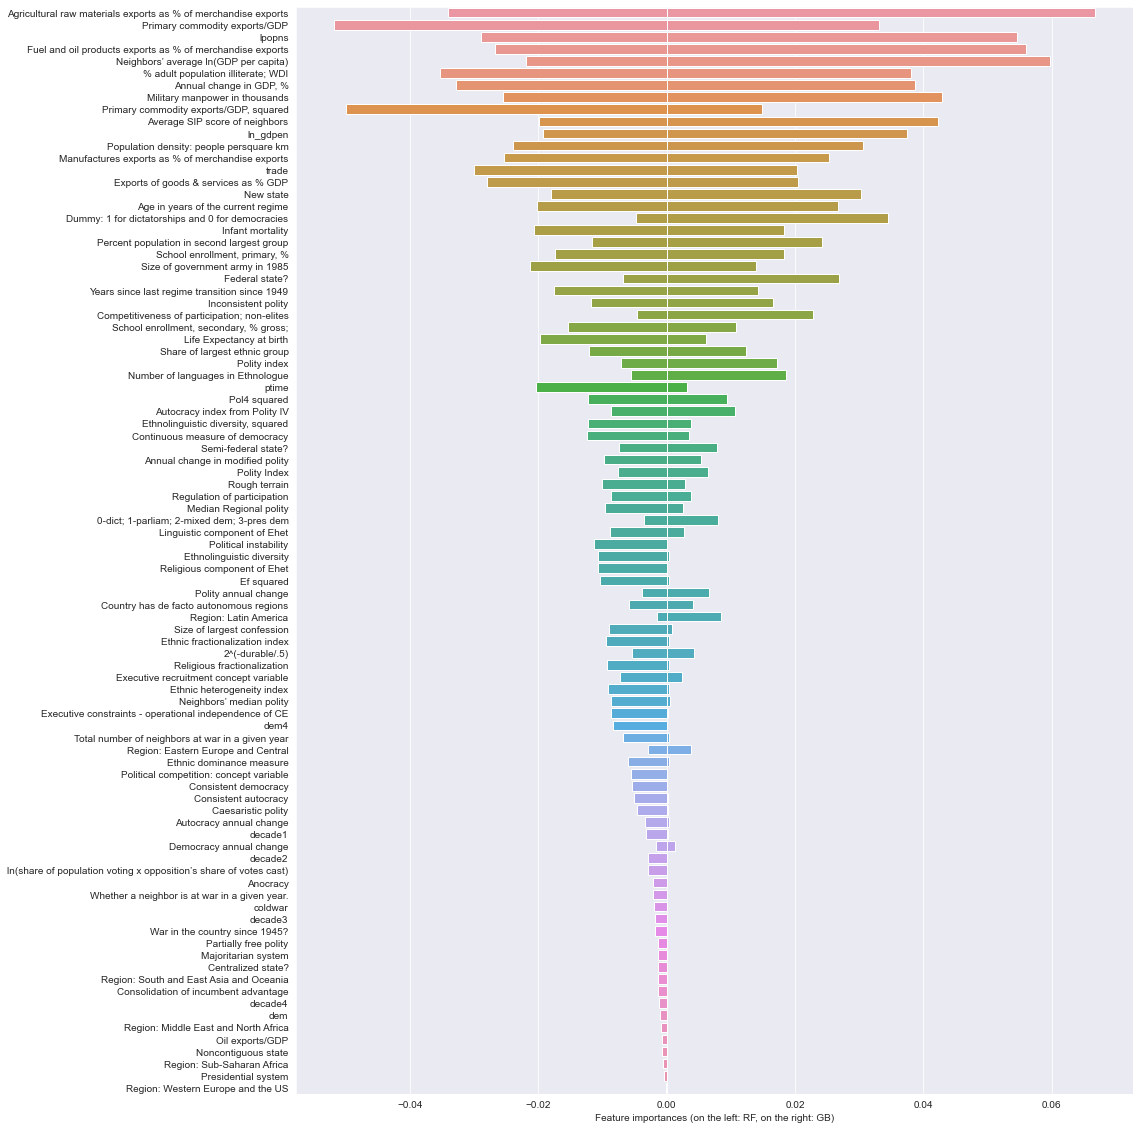

In [71]:
plt.figure(figsize=(15,20))
sns.set_style("darkgrid")

sns.barplot(x=merge['Gradient Boosting'], y=translate(merge.index))

sns.barplot(x=-merge['Random Forest'], y=translate(merge.index))

plt.xlabel('Feature importances (on the left: RF, on the right: GB)')

### 2 _ Terrorism

### terrorism data handling

In [23]:
#The goal of this cell is to add a column with the name of the country then to introduce the terrorism data
#Note: we can then drop StateName column
#Drop useless columns and change names of the 2 remaining ones
cow=cow.drop(['StateAbb'],axis=1)
cow.columns = ['cowcode','country']
#Merge it to doc (into doc_t) that now have a column 'StateName' matching cow code
doc_t = doc.merge(cow)

In [24]:
#Get a list of country and their code (index) for the terrorism dataset
country = df_t[["country", "country_txt"]]
maxval = df_t['country'].max()

lst=[]
for i in range(maxval):
    temp = country[country.country == i]
    if(not temp.empty):
        temp1=country[country.country == i].iloc[0]
        lst.append(temp1.country_txt)
    else:
        #not a country
        lst.append("NAC")
countrylist = pd.DataFrame(lst)

In [25]:
#Calculation of the number of terrorist attacks in each country for each year. Final dataframe is fy1 which contains all years from
#1970 to 2000 with all countries and their number of terrorist attacks
first = df_t[df_t['iyear']==1970]
fc = first[first['country']==200]
maxval = df_t['country'].max()
#Create the index for each year from 1970 to 2000
fy = np.arange(1970, 2000, 1)
fy1 = pd.DataFrame(fy,columns=['year'])
fy1 = fy1.set_index('year')

for i in range(maxval):
    ls=[]
    for j in range(1970,2000):
        temp = df_t[(df_t.country==i)]
        temp2 = len(temp[(temp.iyear==j)])
        ls.append(temp2)
    fy1[i] = ls
    
fy1.columns = [countrylist[0]]
fy1.drop(list(fy1.filter(regex = 'NAC')), axis = 1, inplace = True)

In [26]:
#Tmp is a vector of zeros
tmp = [0]*len(doc_t)
#We iterate on our dataframe (doc_t) and retrieve for each row the year and the country
#then if the values is present in fy1 (we verfy in index and column), the value is changed at the corresponding location in tmp
for index, row in doc_t.iterrows():
    year = row['year']
    country = row['country']
    if( (year in fy1.index) & (country in fy1.columns) ):
        tmp[index]= fy1.loc[year][country].values[0]
#Finally, tmp is placed in doc_t as terrorism column
doc_t['terrorism']=tmp
doc_t=doc_t.drop(['country'],axis=1)

### terrorism study

Text(0.5, 1.0, 'Comaparison of predictions with or without terrorism data (1970-2000)')

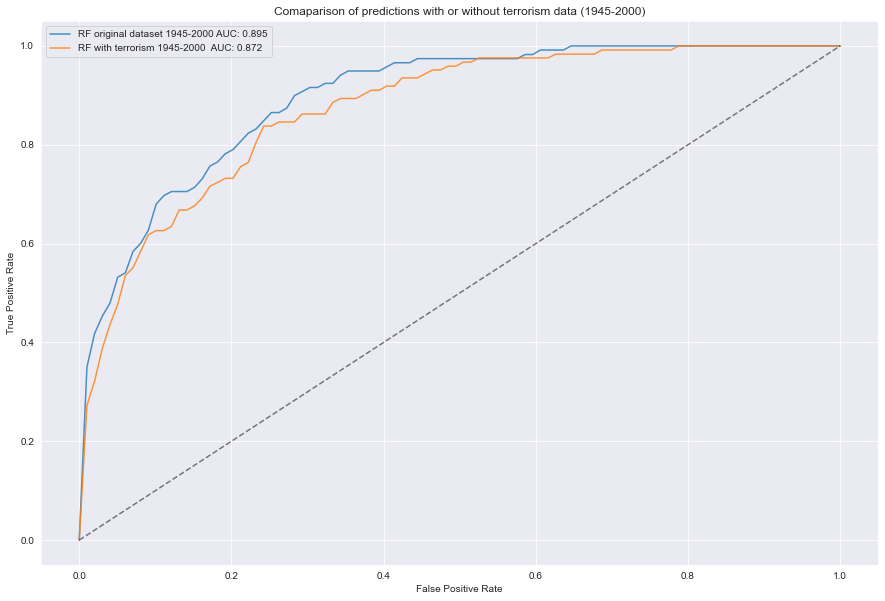

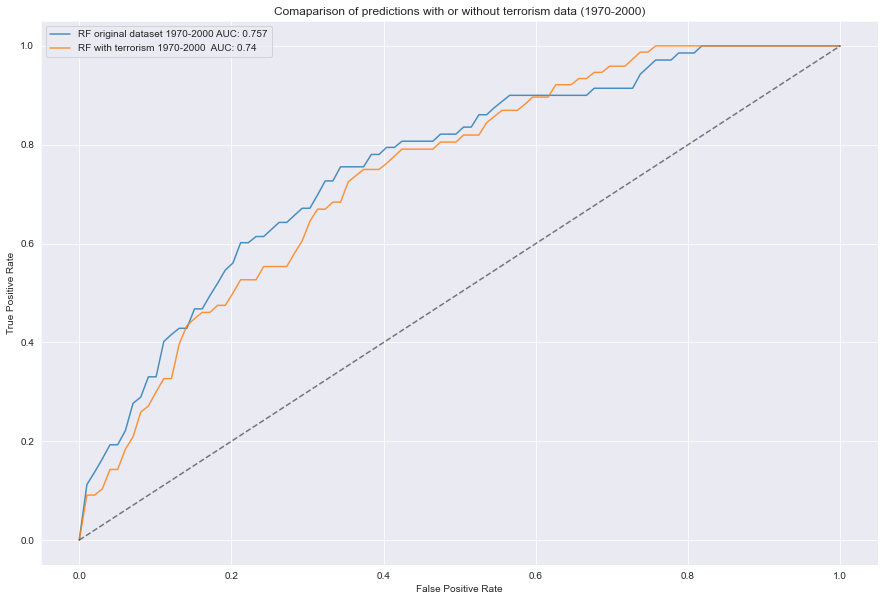

In [36]:
#Original data set (CWD), here we drop year and cowcode because we don't use them
X = doc.drop( ["warstds", "year", "cowcode"] , axis=1 )
y = doc['warstds']

#Terrorism data set
X_t = doc_t.drop( ["warstds", "year", "cowcode"] , axis=1 )
y_t = doc_t['warstds']

#CWD from 1970 to 2000
X70 = doc[ doc['year'] >= 1970 ].drop( ["warstds", "year", "cowcode"] , axis=1 )
y70 = doc[ doc['year'] >= 1970 ]['warstds']

#Terrorism dataset from 1970 to 2000
X_t70 = doc_t[ doc_t['year'] >= 1970 ].drop( ["warstds", "year", "cowcode"] , axis=1 )
y_t70 = doc_t[ doc_t['year'] >= 1970 ]['warstds']

#Creation of Xs and Ys
Xs45 = [ X , X_t,  ]
Ys45 = [ y , y_t,  ]
Xs70 = [ X70 , X_t70 ,  ]
Ys70 = [ y70 , y_t70 ,  ]

#Creation of labels
labs =['RF original dataset all','RF with terrorism all ', 'RF original dataset 70','RF with terrorism 70',]
labs45=[ 'RF original dataset 1945-2000','RF with terrorism 1945-2000 ', ]
labs70=[ 'RF original dataset 1970-2000','RF with terrorism 1970-2000 ', ]

#Plotting the ROC curves of the
rocList(clf,Xs45,Ys45,n=10,labels = labs45,displaymean = False)
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title( 'Comaparison of predictions with or without terrorism data (1945-2000)' )

rocList(clf,Xs70,Ys70,n=10,labels = labs70,displaymean = False)
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title( 'Comaparison of predictions with or without terrorism data (1970-2000)' )

In [37]:
#Ranking from 45, 10 times verif
mean=0
for i in range(10):
    clf.fit( X_t , y_t )
    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X_t.columns , 'importance': clf.feature_importances_  ,   }  )
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    ind = testDF.loc[ testDF['variables'] == 'terrorism'].index[0]
    mean+=ind/10
print( 'mean rank for terrorism on the data from 1945 : ' + str(mean))

#Calculation of the ranking of the feature terrorism from 1970-2000 with 10 times verification
mean=0
for i in range(10):
    clf.fit( X_t70 , y_t70 )
    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X_t70.columns , 'importance': clf.feature_importances_  ,   }  )
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    ind = testDF.loc[ testDF['variables'] == 'terrorism'].index[0]
    mean+=ind/10
print( 'mean rank for terrorism on the data from 1970 : ' + str(mean))

mean rank for terrorism on the data from 1945 : 27.299999999999997
mean rank for terrorism on the data from 1970 : 19.6


## 3 _ Slicing

### Year

<AxesSubplot:>

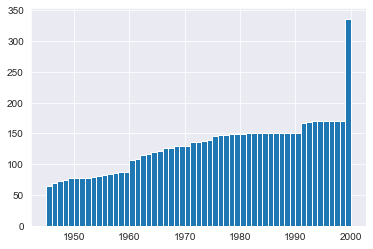

In [38]:
#Histogram to see the repartition of the values accross the years
#We see that there are twice as many variables in the 1990-2000 than in 1950-1960
#But it stay in the same order of magnitude
doc['year'].hist(bins=55)

In [39]:
#Dividing the Dataset into subsets according to a number of years determined by the variable period)
period = 5
vecy=np.arange(1945,2000-period,period)
tab = []
for year in vecy:
    tab.append( doc[ (doc['year'] >= year) & (doc['year'] < year+period) ] )

tab.append(doc[ doc['year'] >= 2000-period ])

for i in range(len(tab)):
    tab[i] = tab[i].drop(['year','cowcode'] , axis='columns')

#pas de changement notable de la proportion total de cas civil war
#resultat non proportionel à la quantité de donnée

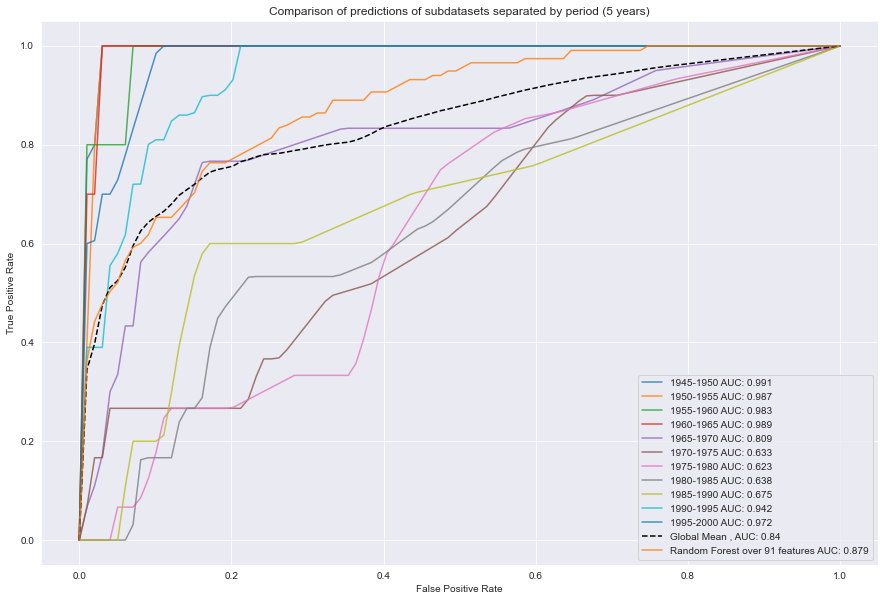

In [40]:
#Plotting of the ROC curve: means of the n cross-validation of each subset (period of time)
xs=[]
ys=[]
for i in tab:
    ys.append( i['warstds'] )
    xs.append( i.drop(['warstds'],axis='columns') )
labs = [ str(i) + '-' + str(i+period) for i in np.arange(1945, 2000, period)]
rocList(clf,xs,ys,n=5,labels=labs)
rocList(clf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['Random Forest over 91 features'], newplot = False, displaymean = False)
plt.title('Comparison of predictions of subdatasets separated by period (5 years)')
plt.legend()

Text(0.5, 1.0, 'AUCs for the different slices of 11 years period')

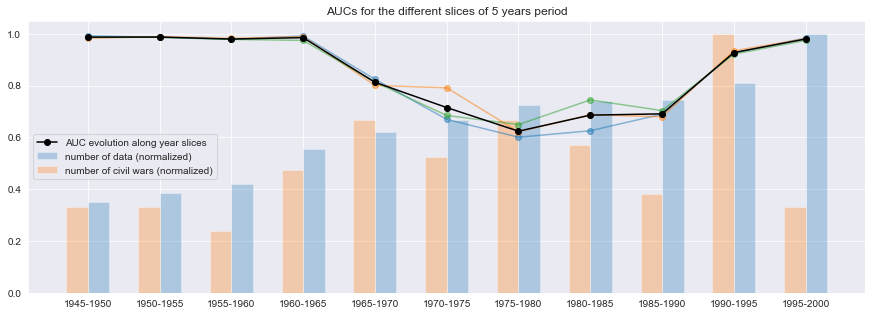

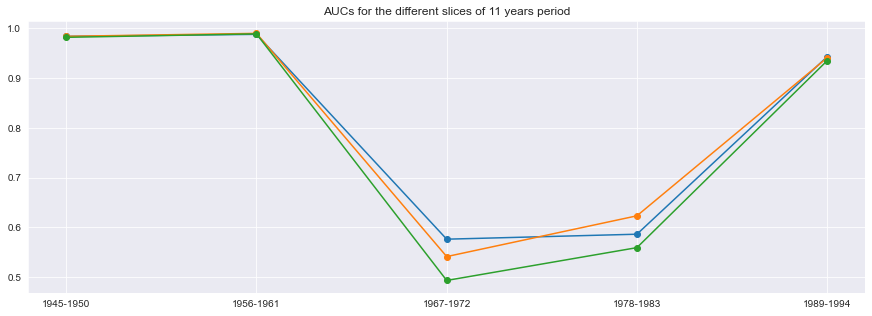

In [41]:
#Graphs of the AUC values for the different slices by period from the graph above
#3 sets of values were taken to be sure it was not a random pattern
#note: the values were picked manually, but are easily reproducible

#On the graph above, we observed that some curves yield very good results, while other slices yield very bad ones.
#Interestingly, this depends on the period of time, and this pattern appears both when we do slices of 5 and 11 years

#Slicing with period = 5 years
plt.figure(figsize=(15,5))
tab_auc1=[ 0.993 , 0.987 , 0.979 , 0.992 , 0.825 , 0.67 , 0.601 , 0.626 , 0.690 , 0.927 , 0.984  ]
vec = np.arange(0,len(tab_auc1),1)
plt.plot(vec,tab_auc1,'o-',alpha=0.5)
tab_auc2=[ 0.983 , 0.99 , 0.983 , 0.99 , 0.801 , 0.792 , 0.622 , 0.688 , 0.68 , 0.935 , 0.982 ]
vec = np.arange(0,len(tab_auc2),1)
plt.plot(vec,tab_auc2,'o-',alpha=0.5)
tab_auc3=[ 0.987 , 0.987  , 0.979 , 0.975 , 0.814 , 0.685, 0.65, 0.745 , 0.704 , 0.922 , 0.975  ]
vec = np.arange(0,len(tab_auc3),1)
plt.plot(vec,tab_auc3,'o-',alpha=0.5)
plt.plot(vec,np.mean([tab_auc1,tab_auc2,tab_auc3],axis=0),'o-',color='k',label = 'AUC evolution along year slices')


labs = [ str(i) + '-' + str(i+5) for i in np.arange(1945, 2000, 5)]
plt.xticks(vec,labels=labs)
plt.title('AUCs for the different slices of 5 years period')

sizes = [len(i) for i in tab]
sizes = sizes / np.max(sizes)
plt.bar( vec,sizes,alpha=0.3,width=0.3,align ='edge',label='number of data (normalized)')
wars = [len( i[i['warstds']==1] ) for i in tab]
wars = wars / np.max(wars)
plt.bar( vec,wars,alpha=0.3,width=-0.3,align ='edge',label='number of civil wars (normalized)')
plt.legend()



#Slicing with period = 11 years
plt.figure(figsize=(15,5))
tab_auc=[ 0.984 , 0.988 , 0.576 , 0.586 , 0.943  ]
vec = np.arange(0,len(tab_auc),1)
plt.plot(vec,tab_auc,'o-')
tab_auc=[ 0.984 , 0.99 , 0.541 , 0.623 , 0.941  ]
vec = np.arange(0,len(tab_auc),1)
plt.plot(vec,tab_auc,'o-')
tab_auc=[ 0.982 , 0.989, 0.493 , 0.559 , 0.935 ]
vec = np.arange(0,len(tab_auc),1)
plt.plot(vec,tab_auc,'o-')
labs = [ str(i) + '-' + str(i+5) for i in np.arange(1945, 2000, 11)]
plt.xticks(vec,labels=labs)
plt.title('AUCs for the different slices of 11 years period')


### GDP per capita

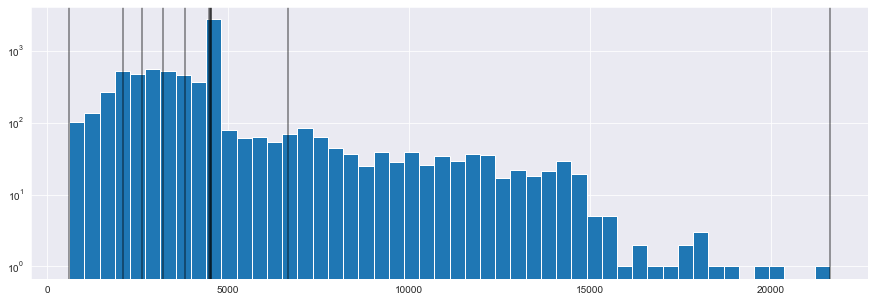

In [46]:
#Visualization of the repartition of the values according to GDP per capita
#We need to use quantiles
plt.figure(figsize=(15,5))
docbis = doc.copy()
doc['nmgdp'].hist(bins=50)
quantile = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k', alpha=0.5)
plt.yscale('log')

In [47]:
#Cutting the dataset into subsets by quantiles
quantile_nmgdp = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
tab_nmgdp=[]
for i in range(10):
    tab_nmgdp.append( doc[ (docbis['nmgdp'] >= quantile_nmgdp.iloc[i]) & (doc['nmgdp'] < quantile_nmgdp.iloc[i+1]) ] )

for i in range(len(tab_nmgdp)):
    tab_nmgdp[i] = tab_nmgdp[i].drop(['year','cowcode'] , axis='columns')

Text(0, 0.5, 'Numer of civil war occurrences')

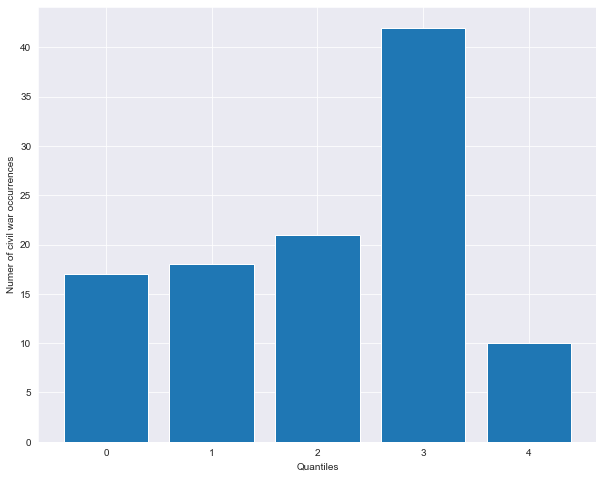

In [65]:
#Number of civil war occurrences per slice
#The 5 last contain too few civil war occurrences, thus we don't consider these slices in the ROC plot below
cw_occurrences = []
for i in tab_nmgdp:
    cw_occurrences.append(len(i[i['warstds']==1]))
plt.figure(figsize = (10,8))
plt.bar(np.arange(0,len(cw_occurrences),1),cw_occurrences)
plt.xlabel('Quantiles')
plt.ylabel('Numer of civil war occurrences')
plt.title('Civil war occurrences per quantile')

Text(0.5, 1.0, 'Comparison of predictions from subdataset sliced by gdp per capita')

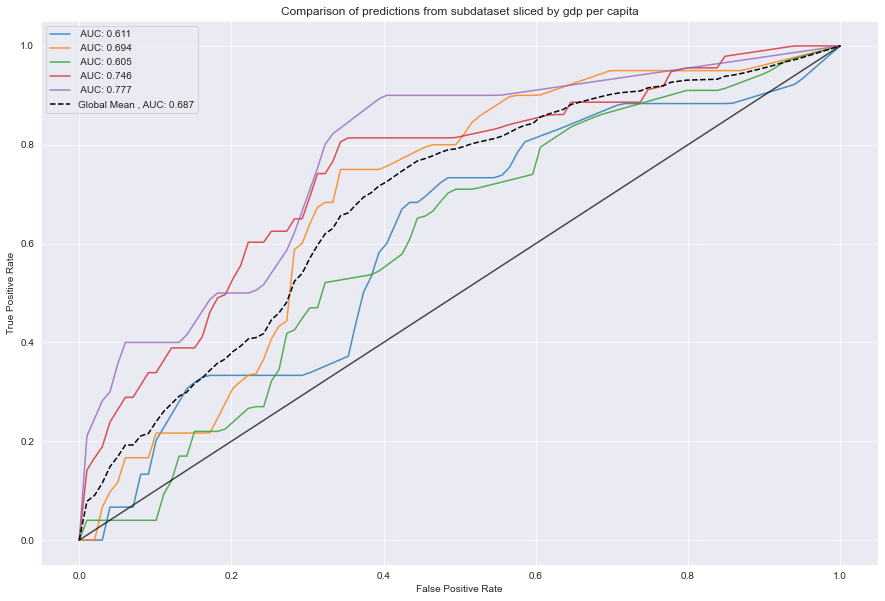

In [49]:
#ROC plot of the sliced GDP per capita 
xs_nmgdp=[]
ys_nmgdp=[]

#We only plot the 5 first values with more than 10 civil war
tab_nmgdp = tab_nmgdp[:5]
for i in tab_nmgdp:
    ys_nmgdp.append( i['warstds'] )
    xs_nmgdp.append( i.drop(['warstds'],axis='columns') )
    
labs_nmgdp = ['1','2','3','4','5','6','7','8','9','10']
rocList(clf,xs_nmgdp,ys_nmgdp,n=5,labels=labs_nmgdp)

plt.plot([0, 1], [0, 1],'k-',alpha = 0.7)
plt.title('Comparison of predictions from subdataset sliced by gdp per capita')

### GPD Growth

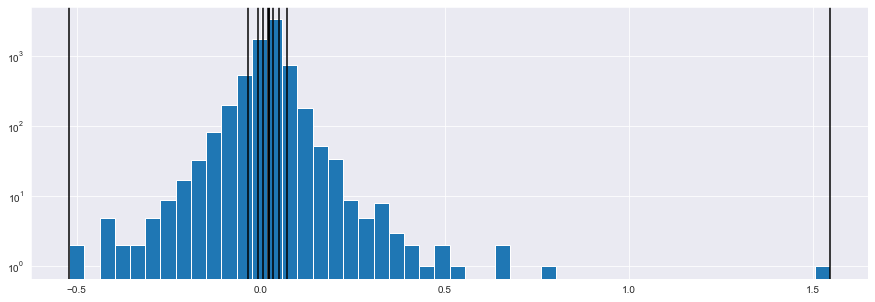

In [50]:
#Visualization of the repartition of the values according to GDP Growth
plt.figure(figsize=(15,5))
doc['gdpgrowth'].hist(bins=50)

quantile = doc['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k')

#log scale
plt.yscale('log')

Text(0.5, 1.0, 'Civil war occurrences per quantile')

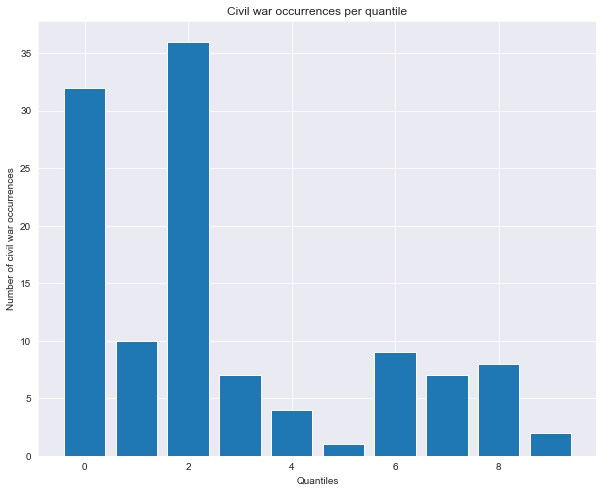

In [66]:
#Cutting the dataset into subsets by quantile
quantile_gdpgrowth = docbis['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
tab_gdpgrowth=[]
for i in range(10):
    tab_gdpgrowth.append( doc[ (docbis['gdpgrowth'] >= quantile_gdpgrowth.iloc[i]) & (doc['gdpgrowth'] < quantile_gdpgrowth.iloc[i+1]) ] )

gdp_occurrences = []
for i in range(len(tab_gdpgrowth)):
    tab_gdpgrowth[i] = tab_gdpgrowth[i].drop(['year','cowcode'] , axis='columns')
    gdp_occurrences.append(len(tab_gdpgrowth[i][tab_gdpgrowth[i]['warstds']==1]))
    
plt.figure(figsize = (10,8))    
plt.bar(np.arange(0,len(gdp_occurrences),1),gdp_occurrences)
plt.xlabel('Quantiles')
plt.ylabel('Number of civil war occurrences')
plt.title('Civil war occurrences per quantile')

Text(0.5, 1.0, 'Comparison of predictions from subdataset sliced by gdp growth')

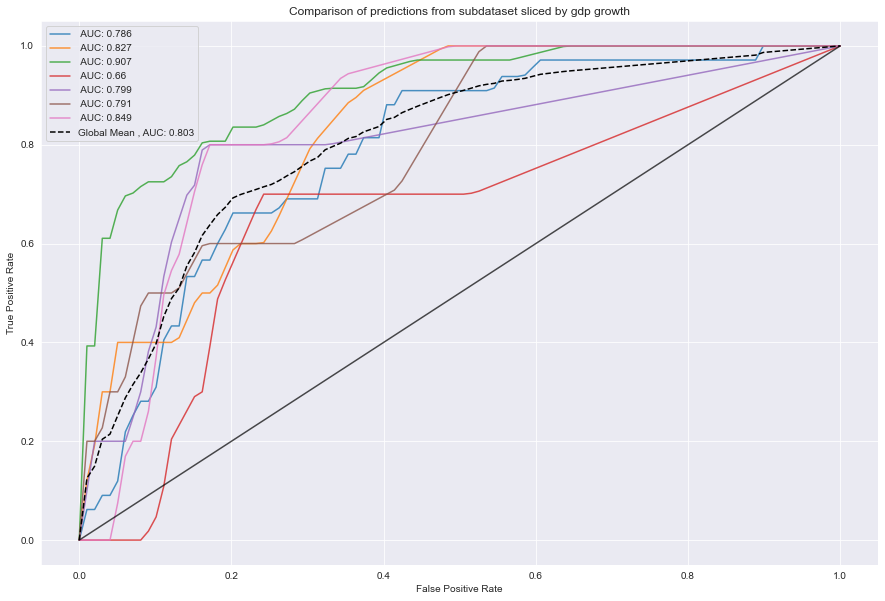

In [52]:
#ROC plot of RF trained on the different slices of GDP growth
xs_gdpgrowth=[]
ys_gdpgrowth=[]

#We only plot the slices with more than 5 civil wars
for i in [ enough for enough in tab_gdpgrowth if len(enough[enough['warstds']==1]) > 5]:
    ys_gdpgrowth.append( i['warstds'] )
    xs_gdpgrowth.append( i.drop(['warstds'],axis='columns') )
rocList(clf,xs_gdpgrowth,ys_gdpgrowth,n=5,labels=labs_nmgdp)
plt.plot([0, 1], [0, 1],'k-',alpha = 0.7)
plt.title('Comparison of predictions from subdataset sliced by gdp growth')

## Part Three

In [53]:
#Calculation of the evolution of nmgdp
doc_evol=doc.copy()
doc_evol['evolnmgdp'] = computeEvol(doc_evol,'nmgdp')

Text(0.5, 1.0, 'gdp per capita evolution for each country')

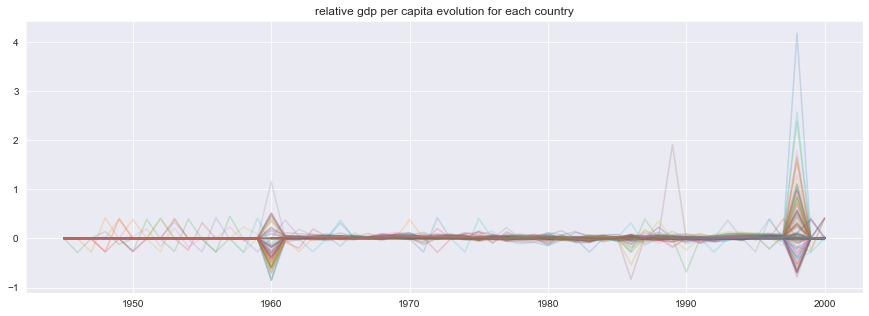

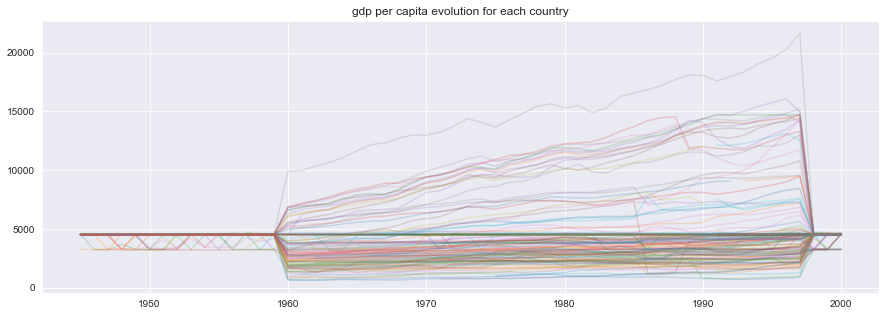

In [54]:
#Plot of the evolution Vs the values themselves
plt.figure(figsize=(15,5))
for country in doc_evol['cowcode'].unique():
    tmp = doc_evol[ doc_evol['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evolnmgdp'],alpha=0.2)
    
plt.title('Relative gdp per capita evolution for each country')
plt.figure(figsize=(15,5))
for country in doc_evol['cowcode'].unique():
    tmp = doc_evol[ doc_evol['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['nmgdp'],alpha=0.2)
plt.title('Gdp per capita evolution for each country')

##These graphs illustrate the change between the 'absolute' old variable and the 'relative' evolution
## -> much less variables accros the countries and time globally

Text(0, 0.5, 'Variables')

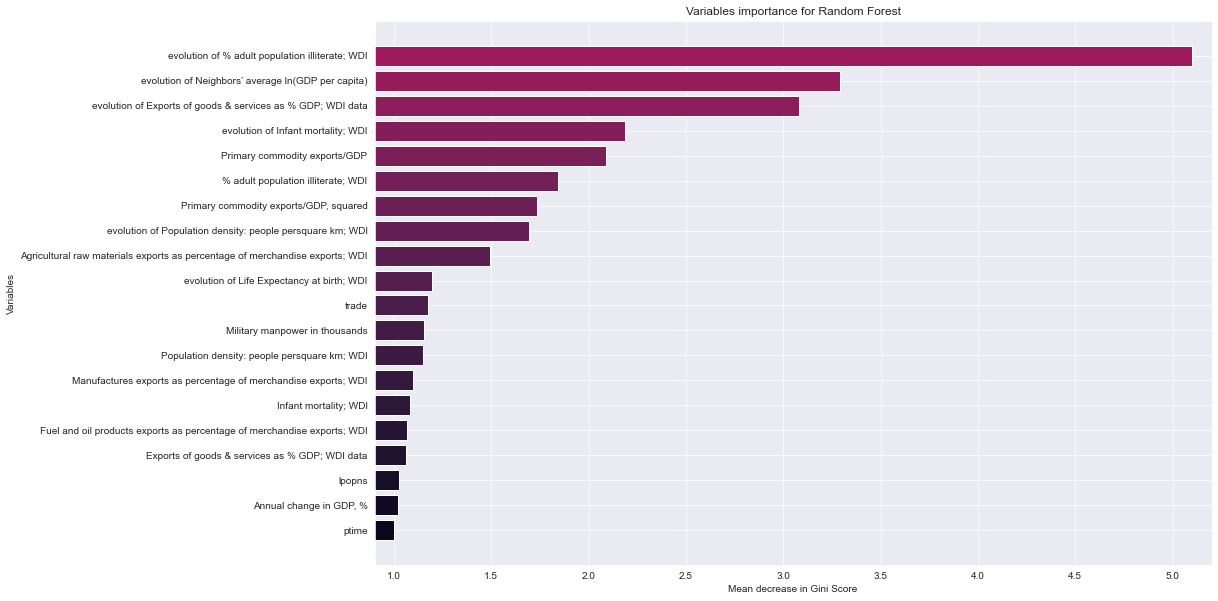

In [55]:
#Plot of the feature importances
fig= plt.figure(figsize=(15,10))

features=['nmgdp','life','infant','expgdp','popdense','illiteracy']
for ft in features:
    doc_evol['evol'+ft] = computeEvol(doc_evol,ft)

#Removal of the features which are not useful for the prediction
X = doc_evol.drop(['warstds','year','cowcode'] , axis='columns')
y = doc_evol['warstds']

#Perform Random Forest method on the data
clf.fit(X,y)

#Matching of the features with their importances provided by the Random Forest classifier
testDF = pd.DataFrame ( { 'variables' : translate(X.columns) ,
                          'importance': clf.feature_importances_  ,
                          }  )
#Sorting the features according to their importance, and keeping only the 20 best features
testDF = testDF.sort_values(by=['importance'] , ascending=True)[-20:]

#Colors palette for the graph
palette = sns.color_palette("rocket",n_colors = 50)

#Plotting of a bar plot with the gini score on the X axis and name of the features on the Y axis
#Note: 'normalization' of the gini score obtained by the minimal value
#We had this first by intuition looking at the original figure as the gini score start from 1, and the result we obtained were very similar to the figure
plt.barh(testDF['variables'],testDF['importance']/testDF['importance'].min(),color = palette  )

#Setting the limit a bit further than the max and min value 
plt.xlim([0.9,testDF['importance'].max()/testDF['importance'].min()+0.1])

#Setting titles for the figure and the axis
plt.title('Variables importance for Random Forest')
plt.xlabel("Mean decrease in Gini Score")
plt.ylabel("Variables")

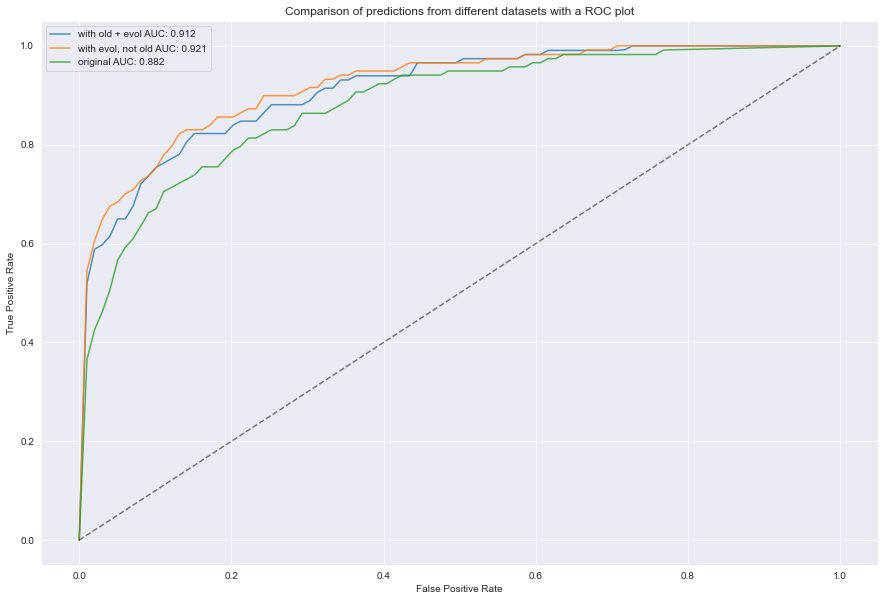

In [56]:
#ROC plot to compare 3 RF models: 
#1. RF trained on the CWD + evolutions of these features: 'nmgdp','life','infant','expgdp','popdense','illiteracy'
#2. RF trained on the CWD and the features which their evolution have been calculated, have been replaced
#3. CWD
X1 = doc_evol.drop(['warstds','year','cowcode','nmgdp','life','infant','expgdp','popdense','illiteracy'] , axis='columns')
X2 = doc_evol.drop(['warstds','year','cowcode','evolnmgdp','evollife','evolinfant','evolexpgdp','evolpopdense','evolilliteracy'] , axis='columns')

Xs = [ X , X1 , X2 ]
Ys = [ y , y , y]
rocList(clf,Xs,Ys,n=10,labels = ['CWD + Evolutions','Replacement of Evolutions in CWD','original CWD'],displaymean = False)
plt.plot([0, 1], [0, 1],'k--','red',alpha = 0.5)

In [57]:
#Features selected to calculate their evolutions
features = ['seceduc', 'pri', 'avgnabo', 'infant', 'ager',
'ptime', 'ln_gdpen', 'nmgdp', 'popdense', 'expgdp',
'lpopns', 'trade', 'manuexp', 'fuelexp', 'milper',
'gdpgrowth', 'illiteracy' ,'agexp', 'sxpsq', 'sxpnew',
'life','terrorism']

scores=[]

for ft in features:
    
    doc_copy = doc_t.copy()
    doc_copy['evol'+ft] = computeEvol(doc_copy,ft)
    #print(len(doc_copy.columns))
    
    #on retire les variables inutiles à la prediction
    X = doc_copy.drop(['warstds','year','cowcode'] , axis='columns')
    y = doc_copy['warstds']

    #perform Random Forest mothod on the data
    clf.fit(X,y)

    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X.columns ,
                              'importance': clf.feature_importances_  ,
                              }  )
    
    #i order the features according to their importance, and keep only the 20 best
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    
    ind_ft = testDF.loc[ testDF['variables'] == ft].index[0]
    ind_evol = testDF.loc[ testDF['variables'] == 'evol'+ft].index[0]
    
    scores.append( ind_ft - ind_evol )
    


<AxesSubplot:xlabel='importance', ylabel='variables'>

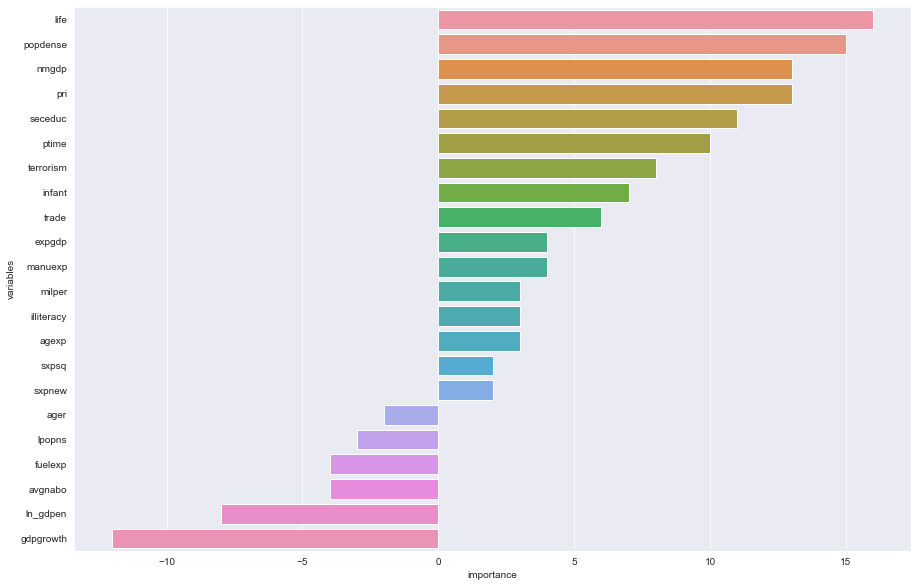

In [58]:
#Plot of the comparisons of the feature importances
testDF = pd.DataFrame ( { 'variables' : features ,
                              'importance': scores  ,
                              }  )
    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)


plt.figure(figsize=(15,10))
sns.barplot(y=testDF['variables'], x=testDF['importance'],)

In [41]:
features = doc_t.drop( ['warstds','year','cowcode'], axis='columns' ).columns.values

scores=[]
clf = RandomForestClassifier(n_estimators=100,max_depth=10)

for ft in features:
    
    doc_copy = doc_t.copy()
    doc_copy['evol'+ft] = computeEvol(doc_copy,ft)
    #on retire les variables inutiles à la prediction
    X = doc_copy.drop(['warstds','year','cowcode'] , axis='columns')
    y = doc_copy['warstds']

    #perform Random Forest mothod on the data
    clf.fit(X,y)

    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X.columns ,
                              'importance': clf.feature_importances_  ,
                              }  )
    
    #i order the features according to their importance, and keep only the 20 best
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    
    ind_ft = testDF.loc[ testDF['variables'] == ft].index[0]
    ind_evol = testDF.loc[ testDF['variables'] == 'evol'+ft].index[0]
    
    scores.append( ind_ft - ind_evol )
    
testDF = pd.DataFrame ( { 'variables' : features , 'importance': scores  , }  )
    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)


Text(0.5, 1.0, 'Gain in rank of Gini Score for the Evolutions compared to original variables')

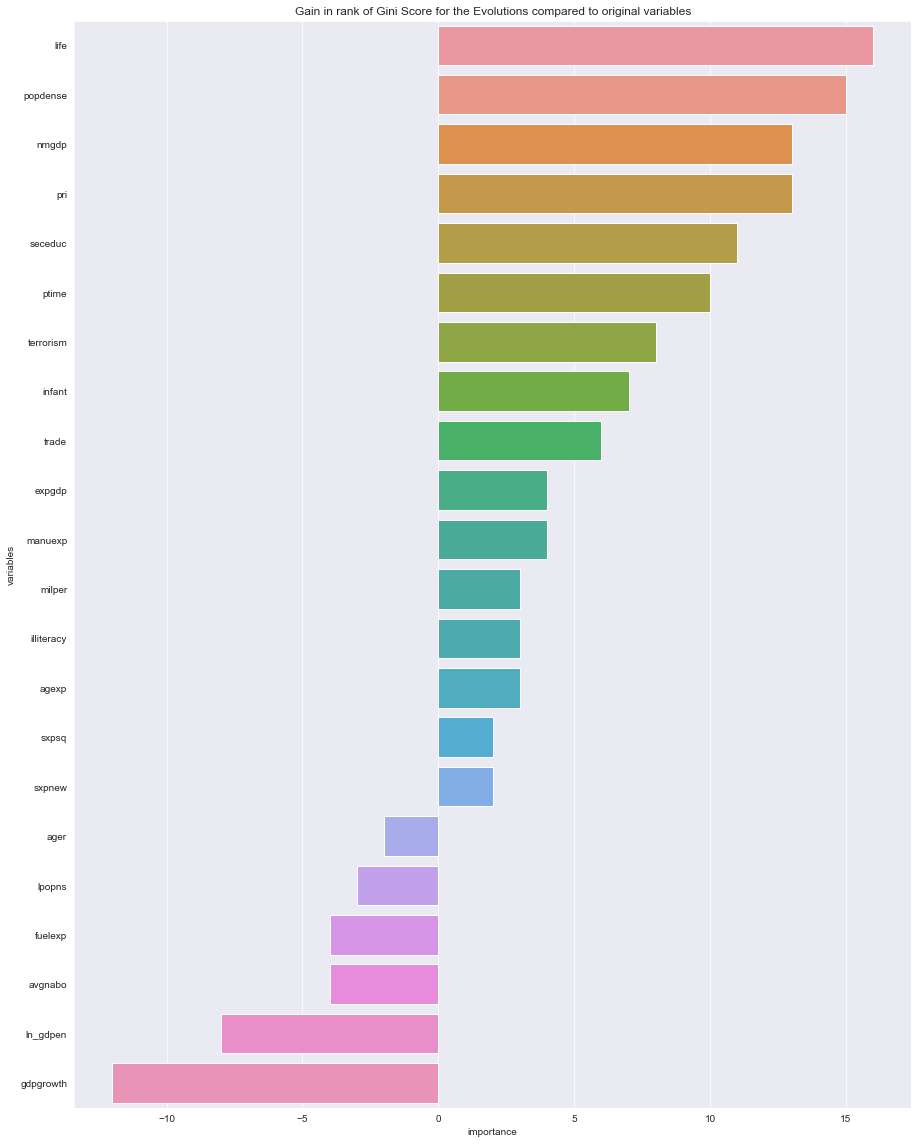

In [67]:
plt.figure(figsize=(15,20))
sns.barplot(y=testDF['variables'], x=testDF['importance'],)
plt.title('Gain in rank of Gini Score for the Evolutions compared to original variables')